# Control: Voicing Contrast Selection

Here we select the voiced and voiceless plosives (ptk vs bdg) to test the model's learning unit. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from IPython.display import Audio
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE   # one type of clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.linalg import block_diag
import pickle
from scipy import stats
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import CTCPredNetV1 as TheLearner
from model_dataset import WordDatasetPath as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import DS_Tools
from reshandler import DictResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU
from misc_tools import AudioCut, ARPABET
import re

In [2]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

In [3]:
# read in guide file
guide_file = pd.read_csv(valid_guide_path)
# filtering out is not necessary, since we only include wuid for encoded words
guide_file = guide_file[~guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]

In [4]:
# words_guide = guide_file.groupby('wuid').apply(lambda x: ([row["segment"] for index, row in x.iterrows()]).tolist()
words_guide_str = guide_file.groupby('wuid').apply(lambda x: (" ".join([row["segment"] for index, row in x.iterrows()]), x["wuid"].iloc[0])).tolist()

In [5]:
def regex_span_to_list_indices(phoneme_str, pattern):
    # Split the string into a list of phonemes
    phonemes = phoneme_str.split()
    # Calculate the cumulative lengths including spaces (add 1 for each space)
    cumulative_lengths = [0]  # Start with 0 for the first phoneme
    for phoneme in phonemes:
        # Add the length of the current phoneme and a space (except for the last one)
        cumulative_lengths.append(cumulative_lengths[-1] + len(phoneme) + 1)
    # Find all matches using re.finditer
    matches = list(re.finditer(pattern, phoneme_str))
    # Map regex span indices to phoneme list indices
    match_indices = []
    for match in matches:
        start, end = match.span()
        # Find the phoneme list index corresponding to the start of the match
        list_start = next(i for i, length in enumerate(cumulative_lengths) if length > start) - 1
        # Find the phoneme list index corresponding to the end of the match (subtract 1 because end is exclusive)
        list_end = next(i for i, length in enumerate(cumulative_lengths) if length >= end) - 1
        match_indices.append((list_start, list_end))
    return match_indices

In [6]:
# stop_pattern = '(?!S) [PTK] (?!R)'
# sibstop_pattern = 'S [PTK] (?!R)'
# Xstop_pattern = stop_pattern
# note that although we only list single-letter vowels, 
# we in fact include all vowels because the all vowels start with one of the listed letters
# the subidx always include pre-stop-vowel. But for Xstop, we don't need the pre
voiceless_stop_pattern = '^[PTK] [AOEIUY]'
voiced_stop_pattern = '^[BDG] [AOEIUY]'

It seems that we have wai da zheng zhao-ed, although the way of selecting was quite wrong if we add any more phoneme, the selected results seem quite right. The only problem is that it seems that the ST sequences have also been included in the XT set. 

Note the difference between stop and Xstop. Stop is at word beginning (but sadly they were not used during previous runnings), and Xstop is word middle.

In [7]:
voiceless_stop_indices = [name for i, (word, name) in enumerate(words_guide_str) if re.search(voiceless_stop_pattern, word)]
voiced_stop_indices = [name for i, (word, name) in enumerate(words_guide_str) if re.search(voiced_stop_pattern, word)]

voiceless_stop_subidx = [regex_span_to_list_indices(word, voiceless_stop_pattern) for i, (word, name) in enumerate(words_guide_str) if re.search(voiceless_stop_pattern, word)]
voiced_stop_subidx = [regex_span_to_list_indices(word, voiced_stop_pattern) for i, (word, name) in enumerate(words_guide_str) if re.search(voiced_stop_pattern, word)]

Here we have the risk of including /t/ for ST but excluding it in XT. 

New selection: this time, we select only those preceding vowels. THerefore, during evaluation, we need to account for the vowels. 

In [8]:
len(voiceless_stop_indices), len(voiced_stop_indices)

(9859, 8406)

In [9]:
voiceless_stop_subidx[0], voiced_stop_subidx[0]

([(0, 1)], [(0, 1)])

In the new version, we also include the following vowels as part of the training set. THis will introduce more noise, but if the trainign is also successful, we can check the attention performances towards both sides. 

In [10]:
def generate_table(df, name_list, target_idx_list, has_pre=True): 
    pre_list = []   # pre can be sibilant or others
    pre_path = []
    pre_startTime = []
    pre_endTimte = []
    stop_list = []
    stop_path = []
    stop_startTime = []
    stop_endTime = []
    vowel_list = []
    vowel_path = []
    vowel_startTime = []
    vowel_endTime = []
    speaker_list = []
    wuid_list = []
    if has_pre:
        for name, target_idx in zip(name_list, target_idx_list): 
            # this is one word, there might be multiple matching cases
            word_phonemes = df[df["wuid"] == name]
            for target in target_idx: 
                target = [i + 1 for i in target]    # Add 1 here because in_id starts from 1
                target_phonemes = word_phonemes[word_phonemes["in_id"].isin(range(target[0], target[1] + 1))]   # the span includes both start and end
                pre = target_phonemes.iloc[0]
                stop = target_phonemes.iloc[1]
                vowel = target_phonemes.iloc[2]
                pre_list.append(pre["segment_nostress"])
                pre_path.append(pre["phone_path"])
                pre_startTime.append(pre["startTime"])
                pre_endTimte.append(pre["endTime"])

                stop_list.append(stop["segment_nostress"])
                stop_path.append(stop["phone_path"])
                stop_startTime.append(stop["startTime"])
                stop_endTime.append(stop["endTime"])

                vowel_list.append(vowel["segment_nostress"])
                vowel_path.append(vowel["phone_path"])
                vowel_startTime.append(vowel["startTime"])
                vowel_endTime.append(vowel["endTime"])

                speaker_list.append(stop["speaker"])
                wuid_list.append(name)
        out_dict = {
            "pre": pre_list, 
            "stop": stop_list,
            "vowel": vowel_list, 
            "pre_path": pre_path, 
            "stop_path": stop_path, 
            "vowel_path": vowel_path,
            "pre_startTime": pre_startTime, 
            "pre_endTime": pre_endTimte, 
            "stop_startTime": stop_startTime,
            "stop_endTime": stop_endTime,
            "vowel_startTime": vowel_startTime,
            "vowel_endTime": vowel_endTime,
            "speaker": speaker_list,
            "wuid": wuid_list
        }
        outdf = pd.DataFrame(out_dict)
    else:
        for name, target_idx in zip(name_list, target_idx_list): 
            # this is one word, there might be multiple matching cases
            word_phonemes = df[df["wuid"] == name]
            for target in target_idx: 
                target = [i + 1 for i in target]    # Add 1 here because in_id starts from 1
                target_phonemes = word_phonemes[word_phonemes["in_id"].isin(range(target[0], target[1] + 1))]
                stop = target_phonemes.iloc[0]
                vowel = target_phonemes.iloc[1]
                pre_list.append("")
                pre_path.append("")
                pre_startTime.append("")
                pre_endTimte.append("")

                stop_list.append(stop["segment_nostress"])
                stop_path.append(stop["phone_path"])
                stop_startTime.append(stop["startTime"])
                stop_endTime.append(stop["endTime"])

                vowel_list.append(vowel["segment_nostress"])
                vowel_path.append(vowel["phone_path"])
                vowel_startTime.append(vowel["startTime"])
                vowel_endTime.append(vowel["endTime"])

                speaker_list.append(stop["speaker"])
                wuid_list.append(name)
        out_dict = {
            "pre": pre_list, 
            "stop": stop_list,
            "vowel": vowel_list, 
            "pre_path": pre_path, 
            "stop_path": stop_path, 
            "vowel_path": vowel_path,
            "pre_startTime": pre_startTime, 
            "pre_endTime": pre_endTimte, 
            "stop_startTime": stop_startTime,
            "stop_endTime": stop_endTime,
            "vowel_startTime": vowel_startTime,
            "vowel_endTime": vowel_endTime,
            "speaker": speaker_list,
            "wuid": wuid_list
        }
        outdf = pd.DataFrame(out_dict)
    return outdf

In [12]:
vldf = generate_table(guide_file, voiceless_stop_indices, voiceless_stop_subidx, has_pre=False)

In [13]:
vddf = generate_table(guide_file, voiced_stop_indices, voiced_stop_subidx, has_pre=False)

In [14]:
vldf["phi_type"] = "T"
vddf["phi_type"] = "D"

In [15]:
vddf.to_csv(os.path.join(src_, "phi-D-guide.csv"), index=False)

In [3]:
sibstopsdf = pd.read_csv(os.path.join(src_, "phi-ST-guide.csv"))

In [5]:
S_st = sibstopsdf["pre_startTime"]
S_et = sibstopsdf["pre_endTime"]

In [6]:
S_dur = S_et - S_st

In [12]:
np.mean(S_dur), np.std(S_dur)

(0.09068133728311471, 0.03271727752124411)

(array([ 15.,  62.,   0., 156.,  27., 209., 333.,   0., 343.,   1., 334.,
        281.,   0., 179.,  28., 109.,  79.,   0.,  70.,   7.,  36.,  22.,
          0.,  16.,   0.,  19.,   9.,   0.,   8.,   1.,   3.,   6.,   0.,
          2.,   0.,   3.,   0.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.]),
 array([0.03 , 0.036, 0.042, 0.048, 0.054, 0.06 , 0.066, 0.072, 0.078,
        0.084, 0.09 , 0.096, 0.102, 0.108, 0.114, 0.12 , 0.126, 0.132,
        0.138, 0.144, 0.15 , 0.156, 0.162, 0.168, 0.174, 0.18 , 0.186,
        0.192, 0.198, 0.204, 0.21 , 0.216, 0.222, 0.228, 0.234, 0.24 ,
        0.246, 0.252, 0.258, 0.264, 0.27 , 0.276, 0.282, 0.288, 0.294,
        0.3  , 0.306, 0.312, 0.318, 0.324, 0.33 ]),
 <BarContainer object of 50 artists>)

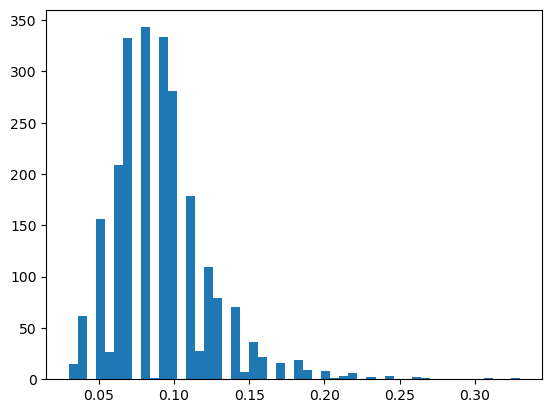

In [10]:
plt.hist(S_dur, bins='auto')

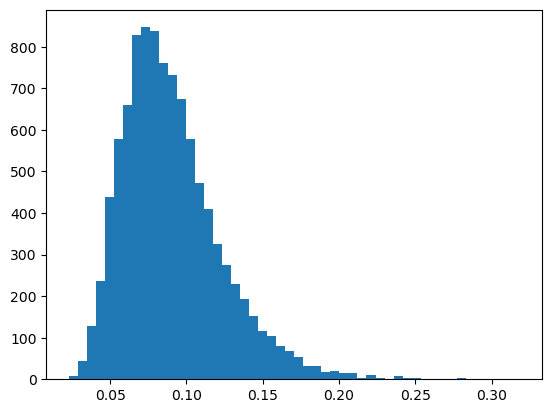

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Given mean and standard deviation
mean = 0.09068133728311471
std = 0.03271727752124411

# Generate a log-normal distribution
sigma = np.sqrt(np.log(1 + (std/mean)**2))
mu = np.log(mean) - 0.5 * sigma**2

# Generate random samples from the log-normal distribution
samples = np.random.lognormal(mean=mu, sigma=sigma, size=10000)

# Plot the histogram of the samples
plt.hist(samples, bins=50)
plt.show()


In [14]:
class SilenceSampler_for_TV: 
    def __init__(self): 
        # mean and std fixed calculated from ST dataset. 
        mean = 0.09068133728311471
        std = 0.03271727752124411

        self.sigma = np.sqrt(np.log(1 + (std/mean)**2))
        self.mu = np.log(mean) - 0.5 * sigma**2
    
    def sample(self, size): 
        samples = np.random.lognormal(mean=self.mu, sigma=self.sigma, size=size)
        return samples
    

class WhiteNoiseGen: 
    def __init__(self, sample_rate, amplitude):
        self.sr = sample_rate
        self.amplitude = amplitude
    
    def generate(self, duration): 
        num_samples = int(duration * self.sr)
        noise = torch.randn(num_samples) * self.amplitude
        noise = noise.unsqueeze(0)
        return noise

In [29]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

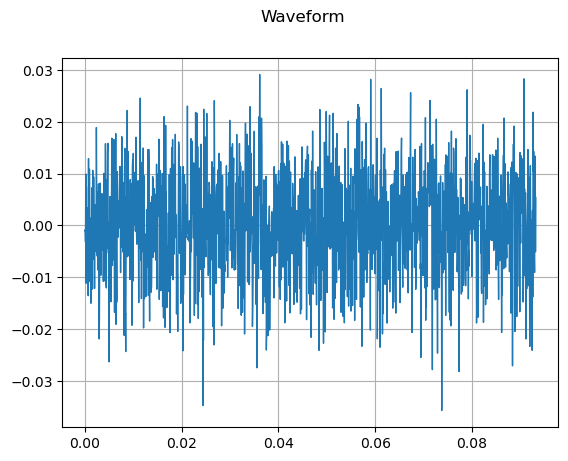

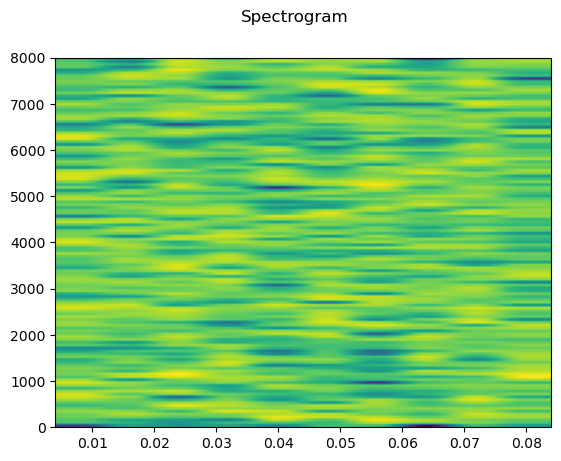

In [56]:
import torchaudio
import torch
import matplotlib.pyplot as plt

# Parameters
durations = SilenceSampler_for_TV().sample(10)
duration = durations[1]  # duration in seconds
sample_rate = 16000  # sample rate in Hz
intensity = 0.01  # intensity of the noise (amplitude scaling factor)

noise_gen = WhiteNoiseGen(sample_rate, intensity)

# Generate white noise
white_noise = noise_gen.generate(duration)


plot_waveform(white_noise, sample_rate)
plot_specgram(white_noise, sample_rate)

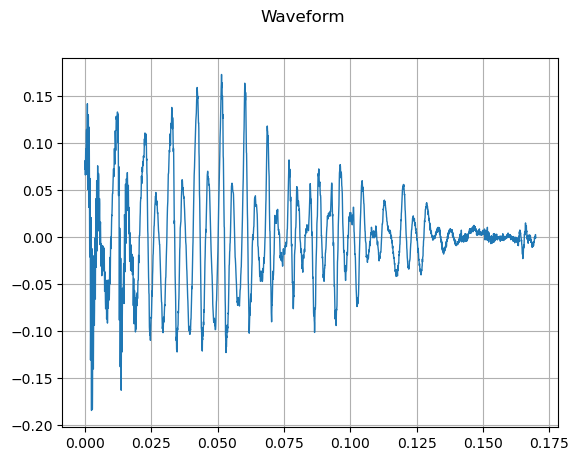

In [55]:
wav, sr = torchaudio.load(os.path.join(train_cut_phone_, "26/495/0001/26-495-0001-0018.flac"))
plot_waveform(wav, sample_rate)
# plot_specgram(wav, sample_rate)